In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paretoset import paretoset
import pygmo as pg
from pymoo.factory import *

In [2]:
os.getcwd() # check current directory

'/rst4_data/workspace6/tatsukawa/Repos/MOEAFramework/post/adaptivesearch'

## Global Parameters
Check these parameters before executing.  
These parameters must be modified to fit the computational conditions.

In [3]:
npop = 100
ngen = 100

nobj = 3
ncon = 0
nvar = 38

ndigits = [2,4,6,8,16]
ntrial = 10

frequency = 3 # frequency of accumulation [gen]

In [4]:
base_path = '../../output/adaptivesearch/cpsd/'

In [5]:
post_path = './result/cpsd/'

In [6]:
algorithmName = ['NSGAII']
problemName = ['DTLZ3', 'DTLZ4']

#### auto-generated parameters

In [7]:
colnames=['gen']
colnames.extend(['obj'+str(i) for i in range(nobj)])
colnames.extend(['con'+str(i) for i in range(ncon)])
colnames.extend(['var'+str(i) for i in range(nvar)])

In [8]:
gs = [i for i in range(0, ngen, frequency)]

In [9]:
# Generate mesh
angle = np.linspace(0, 0.5 * np.pi, 16)
theta, phi = np.meshgrid(angle, angle)
r = 1
X = r * np.cos(phi) * np.cos(theta)
Y = r * np.cos(phi) * np.sin(theta)
Z = r * np.sin(phi)

In [10]:
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']
markers = ['o', '^', 'D', 's', 'h']

In [11]:
cm_name = 'rainbow'
cm = plt.get_cmap(cm_name)

cindex = []
for i in range(cm.N-1, 0, -int(cm.N / len(ndigits))):
    cindex.append(i)

### Function Definitions

#### Utility functions

In [12]:
def makeFileName(header, algorithm, problem, trial, extension):
    if header == '':
        if trial == '':
            return '_'.join([algorithm, problem]) + '.' + extension
        else:
            return '_'.join([algorithm, problem, str(trial)]) + '.' + extension
    else:
        if trial == '':
            return '_'.join([header, algorithm, problem]) + '.' + extension
        else:
            return '_'.join([header, algorithm, problem, str(trial)]) + '.' + extension

In [13]:
def readSummaryData(header, aName, pName, digit):
    path = '/'.join(
        [post_path, pName, str(digit)]
    )
    if not os.path.exists(path):
        os.makedirs(path)
    
    fname = os.path.join(path, makeFileName(header, aName, pName, '', 'csv'))
    
    print(fname)
    df = pd.read_csv(fname, header=0)
    return df

In [14]:
def saveSummaryData(df, header, aName, pName, digit):
    path = '/'.join(
        [post_path, pName, str(digit)]
    )
    if not os.path.exists(path):
        os.makedirs(path)
    
    fname = os.path.join(path, makeFileName(header, aName, pName, '', 'csv'))
    
    df.to_csv(fname, header=True, index=False)

In [15]:
def saveFig(header, aName, pName, digit, trial, extension):
    path = '/'.join(
        [post_path, pName, str(digit)]
    )
    if not os.path.exists(path):
        os.makedirs(path)
    
    fname = os.path.join(path, makeFileName(header, aName, pName, str(trial), extension))
    plt.savefig(fname)

In [16]:
def extractGen(df):
    return df.gen

In [17]:
def extractObjs(df, n):
    cName = ['obj'+str(i) for i in range(n)]
    return df.loc[:, cName]

In [18]:
def extractVars(df, n):
    cName = ['var'+str(i) for i in range(n)]
    return df.loc[:, cName]

In [19]:
def extractCons(df, n):
    cName = ['con'+str(i) for i in range(n)]
    return df.loc[:, cName]

#### Visualization functions

In [20]:
def plot3D_All(x, y, z, px, py, pz):
    amax = max(max(x), max(y),max(z))
    
    fig = plt.figure(figsize=(14,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    ax = fig.add_subplot(111, projection='3d')
    azim, elev = ax.azim, ax.elev
    azim = -45
    ax.view_init(elev, azim)    
    
    ax.plot_surface(X, Y, Z, color = 'w', edgecolor='b', shade=False, rstride = 1, cstride = 1, alpha=0.5)
    ax.scatter(x, y, z, s=10, c= 'b')
    sc = ax.scatter(px, py, pz, s=10, c='r')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('$f_1$', labelpad=15, fontsize=18)
    ax.set_ylabel('$f_2$', labelpad=15, fontsize=18)
    ax.set_zlabel('$f_3$', labelpad=15, fontsize=18)

    ax.set_xlim3d(0, amax)
    ax.set_ylim3d(amax, 0)
    ax.set_zlim3d(0, amax)
#     plt.show()
    
    return fig

In [21]:
def plot3D_ND1(nd_sol):
    px = nd_sol.iloc[:,0]
    py = nd_sol.iloc[:,1]
    pz = nd_sol.iloc[:,2]
    return plot3D_ND(px, py, pz)

In [22]:
def plot3D_ND(px, py, pz):
    amax = max(max(px), max(py),max(pz))
    
    fig = plt.figure(figsize=(14,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    ax = fig.add_subplot(111, projection='3d')
    azim, elev = ax.azim, ax.elev
    azim = -45
    ax.view_init(elev, azim)    
    
    ax.plot_surface(X, Y, Z, color = 'w', edgecolor='b', shade=False, rstride = 1, cstride = 1, alpha=0.5)
    sc = ax.scatter(px, py, pz, s=10, c='r')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('$f_1$', labelpad=15, fontsize=18)
    ax.set_ylabel('$f_2$', labelpad=15, fontsize=18)
    ax.set_zlabel('$f_3$', labelpad=15, fontsize=18)

    ax.set_xlim3d(0, amax)
    ax.set_ylim3d(amax, 0)
    ax.set_zlim3d(0, amax)
    
    return fig

In [23]:
def plot3D_ND2(nd_sol1, nd_sol2):
    px1 = nd_sol1.iloc[:,0]
    py1 = nd_sol1.iloc[:,1]
    pz1 = nd_sol1.iloc[:,2]
    
    px2 = nd_sol2.iloc[:,0]
    py2 = nd_sol2.iloc[:,1]
    pz2 = nd_sol2.iloc[:,2]    
    
    amax = max(max(px1), max(py1), max(pz1), max(px2), max(py2), max(pz2))
    
    fig = plt.figure(figsize=(14,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    ax = fig.add_subplot(111, projection='3d')
    azim, elev = ax.azim, ax.elev
    azim = -45
    ax.view_init(elev, azim)    
    
    ax.plot_surface(X, Y, Z, color = 'w', edgecolor='b', shade=False, rstride = 1, cstride = 1, alpha=0.5)
    ax.scatter(px1, py1, pz1, s=10, c='r')
    sc = ax.scatter(px2, py2, pz2, s=30, c='g')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('$f_1$', labelpad=15, fontsize=18)
    ax.set_ylabel('$f_2$', labelpad=15, fontsize=18)
    ax.set_zlabel('$f_3$', labelpad=15, fontsize=18)

    ax.set_xlim3d(0, amax)
    ax.set_ylim3d(amax, 0)
    ax.set_zlim3d(0, amax)
    
    return fig

In [24]:
def plot_GD_history(summary):
    fig = plt.figure(figsize=(8,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    for trial in range(ntrial):
        plt.plot(summary['gen'], summary[str(trial)], marker='o')

    plt.grid()

    plt.xlabel('Generation')
    plt.ylabel('GD')
    plt.show()

In [25]:
def plot_GD_history(summary):
    fig = plt.figure(figsize=(8,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    for trial in range(ntrial):
        plt.plot(summary['gen'], summary[str(trial)], marker='o')

    plt.grid()

    plt.xlabel('Generation')
    plt.ylabel('GD')
    plt.show()

In [43]:
def plot_GD_histories(summaries, ylim=None):
    fig = plt.figure(figsize=(8,7), dpi=100) # figure size
    plt.rcParams["font.size"] = 22 # whole font size

    for index, digit in enumerate(ndigits):
        data = summaries[index]
        label = ''.join([str(digit), ' digit'])
        marker = markers[index % len(markers)]
        color = cm(cindex[index % len(markers)])
        linestyle = linestyles[index % len(linestyles)]

        plt.plot(data['gen'], data['Ave'], marker=marker, linestyle=linestyle, color=color, label=label)
        plt.errorbar(data['gen'], data['Ave'], data['STD'], color=color, linestyle='None', capsize=4)

    plt.yscale("log")
    
    if ylim != None:
        plt.ylim(ylim)

    plt.grid()

    plt.xlabel('Generation')
    plt.ylabel('GD')

    plt.legend()
    plt.show()

### Main

In [27]:
aName = algorithmName[0]


./result/cpsd//DTLZ2/2/GD_NSGAII_DTLZ2.csv
./result/cpsd//DTLZ2/4/GD_NSGAII_DTLZ2.csv
./result/cpsd//DTLZ2/6/GD_NSGAII_DTLZ2.csv
./result/cpsd//DTLZ2/8/GD_NSGAII_DTLZ2.csv
./result/cpsd//DTLZ2/16/GD_NSGAII_DTLZ2.csv


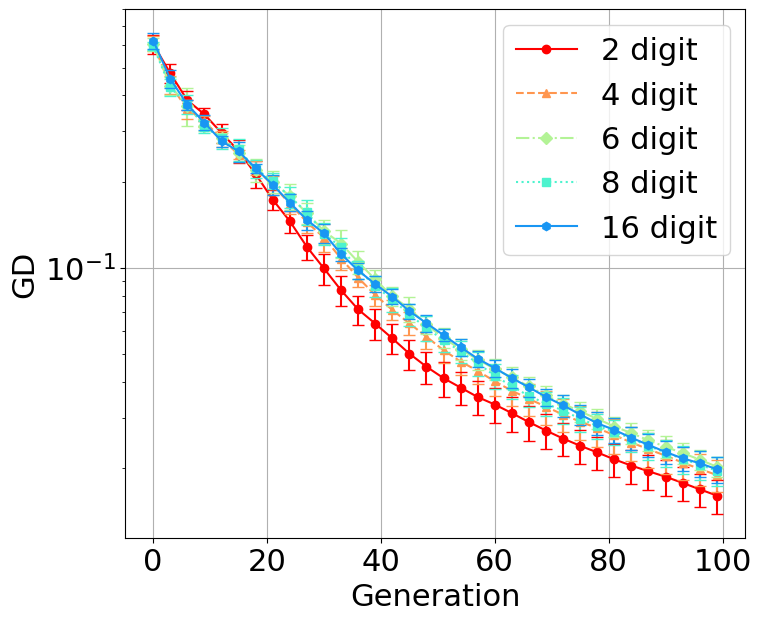

In [44]:
pName = 'DTLZ2'

summaries = []
for digit in ndigits:
    summaries.append(readSummaryData('GD', aName, pName, digit))
    
fig = plot_GD_histories(summaries)

./result/cpsd//DTLZ3/2/GD_NSGAII_DTLZ3.csv
./result/cpsd//DTLZ3/4/GD_NSGAII_DTLZ3.csv
./result/cpsd//DTLZ3/6/GD_NSGAII_DTLZ3.csv
./result/cpsd//DTLZ3/8/GD_NSGAII_DTLZ3.csv
./result/cpsd//DTLZ3/16/GD_NSGAII_DTLZ3.csv


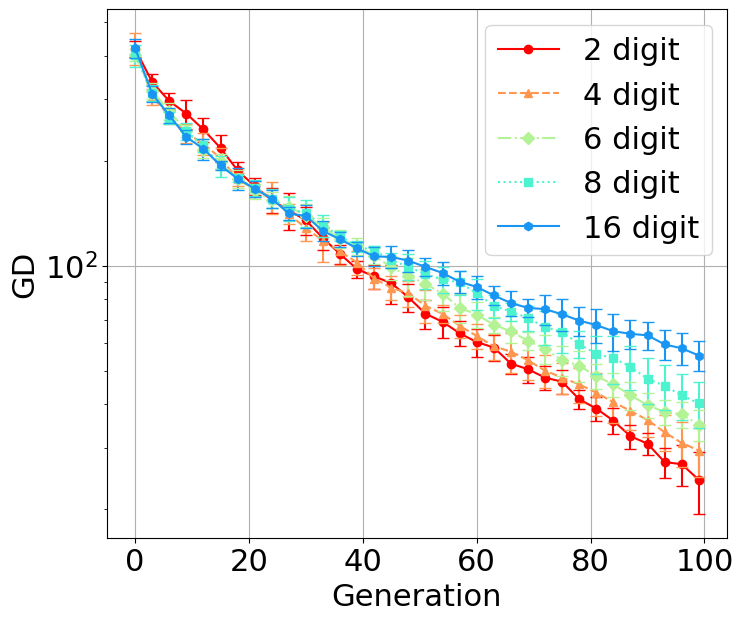

In [41]:
pName = 'DTLZ3'

summaries = []
for digit in ndigits:
    summaries.append(readSummaryData('GD', aName, pName, digit))
    
fig = plot_GD_histories(summaries)

./result/cpsd//DTLZ4/2/GD_NSGAII_DTLZ4.csv
./result/cpsd//DTLZ4/4/GD_NSGAII_DTLZ4.csv
./result/cpsd//DTLZ4/6/GD_NSGAII_DTLZ4.csv
./result/cpsd//DTLZ4/8/GD_NSGAII_DTLZ4.csv
./result/cpsd//DTLZ4/16/GD_NSGAII_DTLZ4.csv


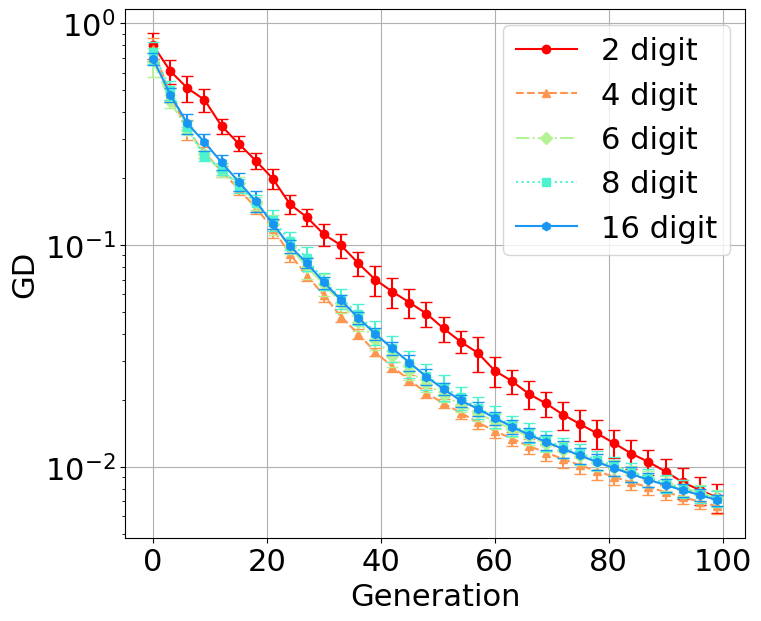

In [42]:
pName = 'DTLZ4'

summaries = []
for digit in ndigits:
    summaries.append(readSummaryData('GD', aName, pName, digit))
    
fig = plot_GD_histories(summaries)